In [1]:
""" (NS GAN)
Vanilla GAN using MLP architecture, non-saturating loss as laid out in the original paper.
Compared to MM GAN, the only change is the generator's loss. In particular:

NS GAN: L(G) = -E[log(D(G(z)))]
MM GAN: L(G) =  E[log(1-D(G(z)))]

https://arxiv.org/abs/1406.2661

From the abstract: 'We propose a new framework for estimating generative models via an adversarial
process, in which we simultaneously train two models: a generative model G
that captures the data distribution, and a discriminative model D that estimates
the probability that a sample came from the training data rather than G. The training
procedure for G is to maximize the probability of D making a mistake.'

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_var(x):
    """ Utility function to automatically cudarize when converting to Variable """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [8]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Discriminator. Input is an image (real or generated), output is P(generated). """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination
    
class NSGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator (D) and Generator (G) """
        super(NSGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
    
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 2e-4, D_lr = 2e-4, D_steps = 1):
        """ Train a vanilla GAN using the non-saturating gradients loss for the generator. 
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            model: class, initialized GAN nn.module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 2e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 2e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 1)
        Outputs:
            model: trained GAN instance
        """
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using samples from the generator, compute sigmoid cross entropy loss to get D_loss = loss(D(x)) + loss(D(G(x)))
                    D_loss = self.train_D(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss)
                
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator using predictions from D on the noise compared to true image labels
                G_loss = self.train_G(model, images)
                
                # Log results, update parameters
                G_losses.append(G_loss)
                G_loss.backward()
                G_optimizer.step()
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
        
        return model
    
    def train_D(self, model, images):
        """ Run 1 step of training for discriminator
        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
            
        Output:
            DX_loss: loss for true images vs D(x)
            DG_loss: loss for generated images vs D(G(x))
            DX_score: probability real images are generated
            DG_score: probability generated images are generated
            
        Variables:
            noise: randomly compute noise, x'
            G_output: G(x'), generated images from G
            DX_score: D(x), probability x is generated where x are true images
            DG_score: D(G(x')), probability G(x') is generated where x' is noise
        """    
        # Generate labels for the real batch images (all 1, since they are real)
        X_labels = to_var(torch.ones(images.shape[0], 1)) 
        
        # Classify the real batch images, get the loss for these 
        DX_score = model.D(images)
        DX_loss = F.binary_cross_entropy(DX_score, X_labels)
        
        # Sample outputs from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_labels = to_var(torch.zeros(images.shape[0]))
        G_output = model.G(noise)
        
        # Classify the fake batch images, get the loss for these (labels being all 0, since they are fake)
        DG_score = model.D(G_output)
        DG_loss = F.binary_cross_entropy(DG_score.squeeze(), G_labels)
        
        # Compute vanilla non-saturating D loss
        D_loss = DX_loss + DG_loss
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        Input:
            model: instantiated GAN
            images: batch of images reshaped to [batch_size, -1]
            
        Output:
            G_loss: loss for how well G(x') fools D
        
        Variables:
            noise: randomly generated noise, x'
            G_output: G(x')
            DG_score: D(G(x'))
        """        
        # Generate labels for the generator batch images (all 0, since they are fake)
        G_labels = to_var(torch.ones(images.shape[0], 1)) 
        
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        DG_score = model.D(G_output)
        
        # Compute the loss for how D did versus the generations of G using sigmoid cross entropy
        G_loss = F.binary_cross_entropy(DG_score, G_labels)
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, z_dim))
    
    def generate_images(self, model, epoch, num_outputs = 36, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/ns-gan/'):
                os.makedirs('../viz/ns-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/ns-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images
    
    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath)
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = NSGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/100], G Loss: 2.5857, D Loss: 0.3963


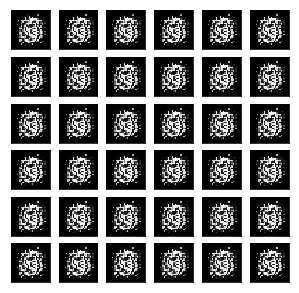

KeyboardInterrupt: 

In [9]:
model = NSGAN(image_size = 784, hidden_dim = 256, z_dim = 128)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 100, G_lr = 2e-4, D_lr = 2e-4, D_steps = 1)